In [1]:
#Hyperparameter tuning
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [2]:
from handyspark import *

In [3]:
#from LC_Hyperparameter_Tuning_Helper import make_pipeline

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession\
    .builder\
    .appName("LC_Model_Selection")\
    .getOrCreate()

In [6]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df, num_att, cat_att):        
    stages= []

    for col in cat_att:

        stringIndexer = StringIndexer(inputCol = col , outputCol = col + '_StringIndex')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + '_ClassVect'])
        stages += [stringIndexer, encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_att] + num_att
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)
    
    return out_df

In [7]:
#Reload from Train and Test 

In [8]:
train_df = spark.read.option('inferschema','true').csv('data/baseline/smote_training.csv', header=True)

In [9]:
test_df = spark.read.option('inferschema','true').csv('data/baseline/smote_test.csv', header=True)

In [10]:
test_df.toPandas().shape

(6103, 57)

In [11]:
train_df.toPandas().shape

(24582, 57)

In [12]:
#Creating list of categorical and numeric features
cat_cols = [item[0] for item in train_df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in train_df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]

In [13]:
#We will choose these features for our baseline model:
num_features, cat_features = num_cols, cat_cols

In [14]:
#Removing the target feature from pipeline inputs
num_features.remove("label")

In [15]:
#Transform Dataset
df_train = make_pipeline(train_df, num_features, cat_features)
input_data_train = df_train.rdd.map(lambda x: (x["label"], DenseVector(x["features"])))
df_train = spark.createDataFrame(input_data_train, ["label", "features"])

In [16]:
#Transform Dataset
df_test = make_pipeline(test_df, num_features, cat_features)
input_data_test = df_test.rdd.map(lambda x: (x["label"], DenseVector(x["features"])))
df_test = spark.createDataFrame(input_data_test, ["label", "features"])

In [17]:
#Recreating the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=0.1)

In [18]:
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, np.arange(0,1,0.05))\
    .build()

In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="label")

In [20]:
# In this case the estimator is simply the logistic regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [21]:
tvs.setCollectSubModels(True)

TrainValidationSplit_3499e0c79fe2

In [22]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(df_train)

In [23]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
predictions_ht = model.transform(df_test)

In [24]:
#for learning curves for given model> specifies cost function at each iteration
#model.subModels[1].summary.objectiveHistory

In [25]:
val_accuracy = model.validationMetrics

In [26]:
train_accuracy = [i.summary.accuracy for i in model.subModels]

In [27]:
en_results = pd.DataFrame({'ENParam':np.arange(0,1,0.05),'Train':train_accuracy, 'Val':val_accuracy})

In [28]:
en_results.set_index("ENParam", inplace=True)

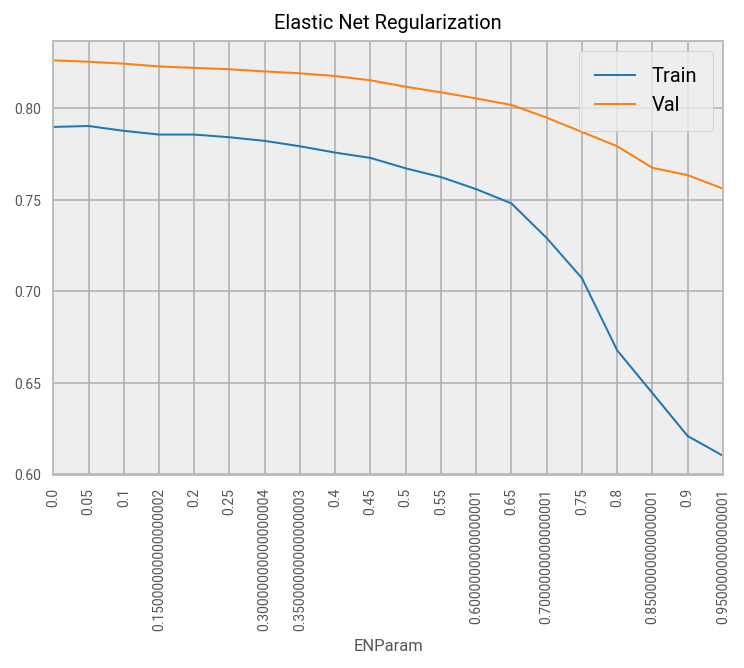

In [29]:
ax = en_results.plot()
ax.set_xticks(np.arange(0,1,0.05))
ax.set_xticklabels(np.arange(0,1,0.05), rotation=90)
ax.set_title("Elastic Net Regularization")
plt.show()

Val Curves Across Regularization Parameter

In [30]:
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.1])\
    .build()

In [31]:
# In this case the estimator is simply the logistic regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [32]:
tvs.setCollectSubModels(True)

TrainValidationSplit_c03278878231

In [33]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(df_train)

In [34]:
train_accuracy = [i.summary.accuracy for i in model.subModels]

In [35]:
val_accuracy = model.validationMetrics

In [36]:
reg_results = pd.DataFrame({'RegParam':[0.00001, 0.0001, 0.001, 0.01, 0.1],'Train':train_accuracy, 'Val':val_accuracy})

In [37]:
reg_results.set_index("RegParam", inplace=True)

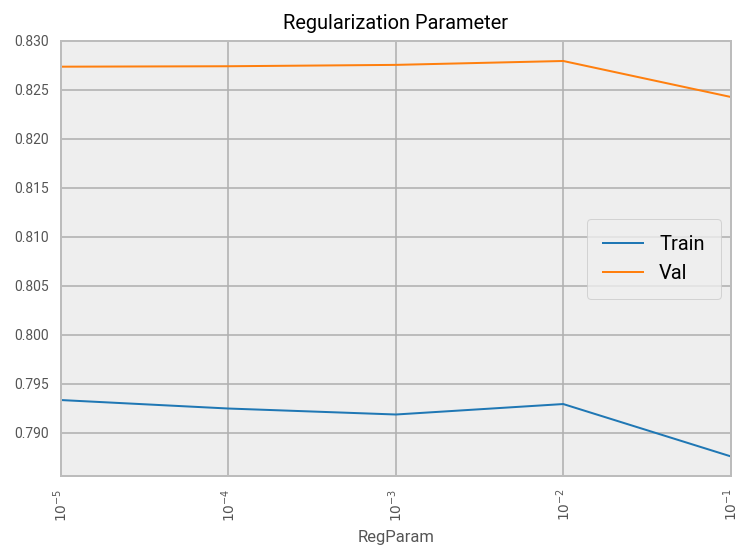

In [38]:
ax = reg_results.plot()
ax.set_xticks([0.00001, 0.0001, 0.001, 0.01, 0.1])
ax.set_xticklabels([0.00001, 0.0001, 0.001, 0.01, 0.1], rotation=90)
ax.set_title("Regularization Parameter")
ax.set_xscale('log')
plt.show()

Learning Curves

In [39]:
train_train, train_val = df_train.randomSplit([0.8, 0.2], seed=1)
#Do stratified sampling here?

In [40]:
#Recreating the Logistic Regression model
lr_train = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=0.4)

In [41]:
# Fit the model
lrModel_train = lr_train.fit(train_train)

In [42]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary_train = lrModel_train.summary

In [43]:
# Obtain the objective per iteration
objectiveHistory_train = trainingSummary_train.objectiveHistory

In [44]:
#On Val

In [45]:
#Recreating the Logistic Regression model
lr_val = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=0.3)

In [46]:
# Fit the model
lrModel_val = lr_val.fit(train_val)

In [47]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary_val = lrModel_val.summary

In [48]:
# Obtain the objective per iteration
objectiveHistory_val = trainingSummary_val.objectiveHistory

In [49]:
obj_hist_df = pd.DataFrame(zip([objective for objective in objectiveHistory_train],[objective for objective in objectiveHistory_val]), columns=['Train', 'Val'])

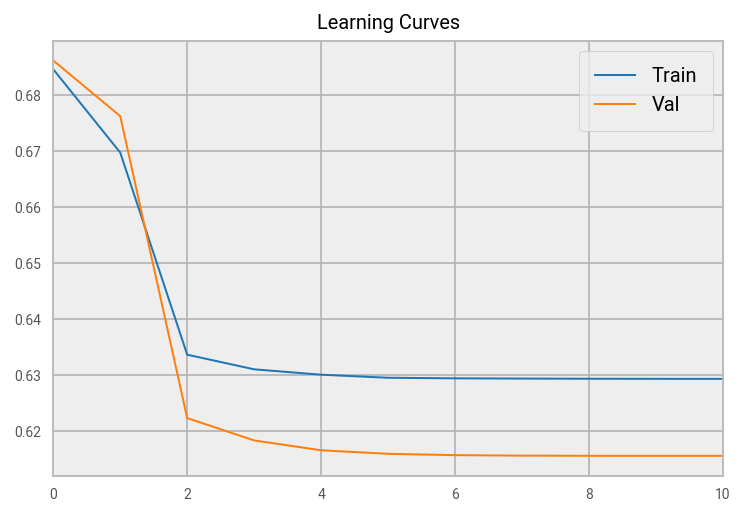

In [50]:
ax = obj_hist_df.plot()
ax.set_title("Learning Curves")
plt.show()

In [51]:
#Recreating the Chosen Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=0.01)

In [52]:
# Fit the model
lrModel = lr.fit(df_train)

In [53]:
#save the model here
#lrModel.save('data/baseline/models/final_baseline')

In [54]:
predictions = lrModel.transform(df_test)

Model Evaluation

In [55]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

In [56]:
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

In [57]:
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.7061
Area under PR Curve: 0.6134


In [58]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')

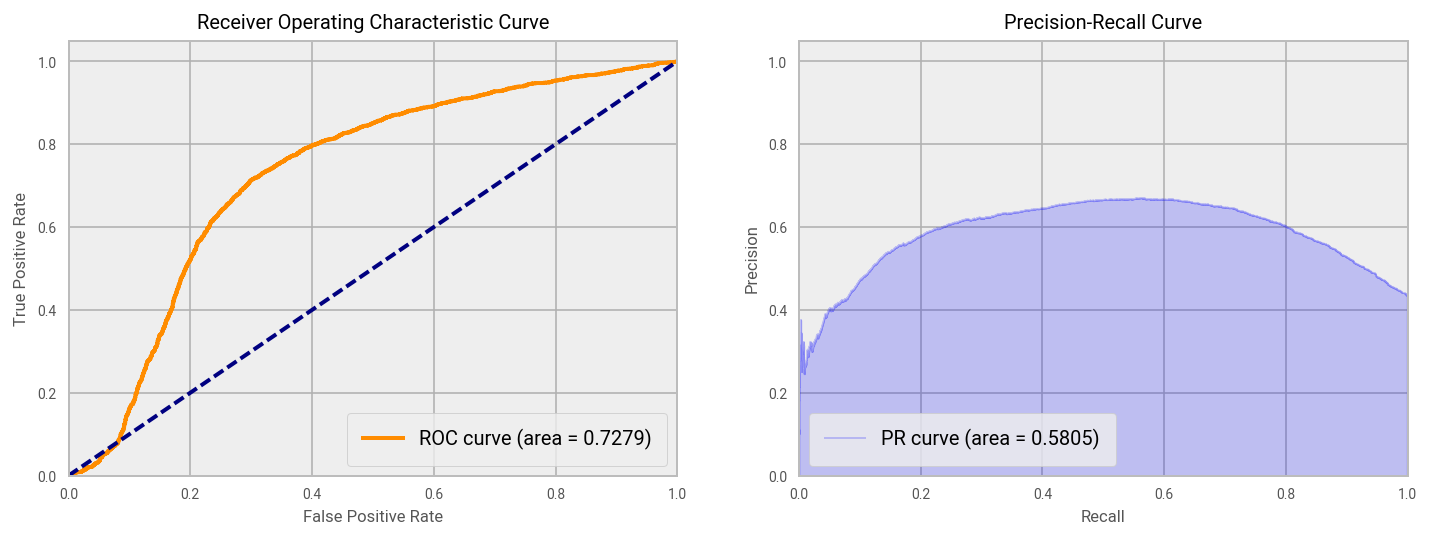

In [59]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [60]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')

In [61]:
# We can obtain the confusion matrix for any arbitrary threshold 
cm = bcm.print_confusion_matrix(.5)

In [62]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

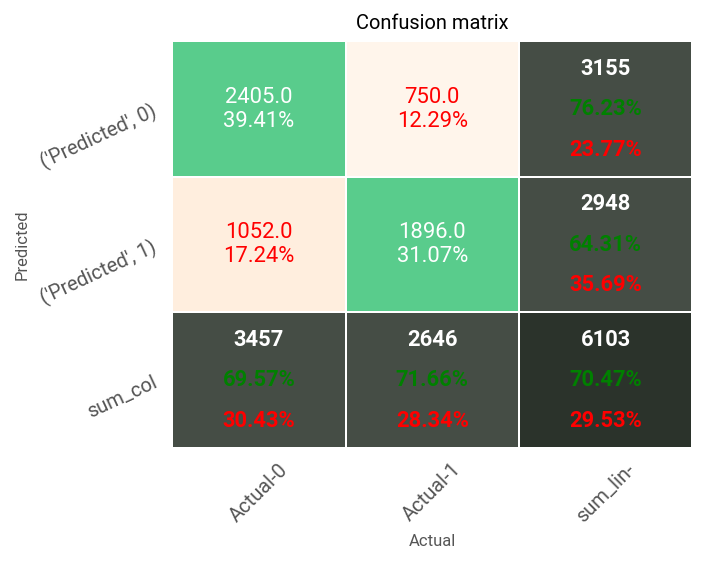

In [63]:
pretty_plot_confusion_matrix(cm, figsize=[5,4])
plt.show()

In [121]:
#We assign a cost to each of the four items in the quadrant
fp_cost = 10
fn_cost = 1600
tp_cost = 0
tn_cost = 100

In [122]:
#We assign a financial gain to true positives
tn_gain = 2000

In [123]:
def campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tp = cm.iloc[1,1]
    num_tn = cm.iloc[0,0]
    num_fp = cm.iloc[0,1]
    num_fn = cm.iloc[1,0]
    
    #Calculate total costs:
    campaign_cost = num_tp*tp_cost + num_tn*tn_cost + num_fp*fp_cost + num_fn*fn_cost
    campaign_gain = num_tn*tn_gain - campaign_cost
    
    print("The estimate campaign outcome with all customers is: ", campaign_gain, " with Decision Threshold: ", thres)
    return campaign_gain

In [124]:
def campaign_outcome_predicted(cm, fn_cost, tn_cost, tn_gain, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tn = cm.iloc[0,0]
    num_fn = cm.iloc[1,0]
    
    #Calculate total costs:
    campaign_cost = num_tn*tn_cost + num_fn*fn_cost 
    campaign_gain = num_tn*tn_gain - campaign_cost
    
    print("The estimate campaign outcome with selected customers is: ", campaign_gain, " with Decision Threshold: ", thres)
    return campaign_gain

In [125]:
campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, 0.5)

The estimate campaign outcome with all customers is:  3358980.0  with Decision Threshold:  0.5


3358980.0

In [126]:
campaign_outcome_predicted(cm, fn_cost, tp_cost, tn_gain, 0.5)

The estimate campaign outcome with selected customers is:  3610000.0  with Decision Threshold:  0.5


3610000.0

In [127]:
gains_all = []
gains_predicted = []
for thres in np.arange(0,1,0.1):
    campaign_gain_all = campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, thres)
    campaign_gain_predicted = campaign_outcome_predicted(cm, fn_cost, tp_cost, tn_gain, thres)
    gains_all.append((thres, campaign_gain_all))
    gains_predicted.append((thres, campaign_gain_predicted))

The estimate campaign outcome with all customers is:  -34570.0  with Decision Threshold:  0.0
The estimate campaign outcome with selected customers is:  0.0  with Decision Threshold:  0.0
The estimate campaign outcome with all customers is:  173780.0  with Decision Threshold:  0.1
The estimate campaign outcome with selected customers is:  219600.0  with Decision Threshold:  0.1
The estimate campaign outcome with all customers is:  1149150.0  with Decision Threshold:  0.2
The estimate campaign outcome with selected customers is:  1249600.0  with Decision Threshold:  0.2
The estimate campaign outcome with all customers is:  2272740.0  with Decision Threshold:  0.30000000000000004
The estimate campaign outcome with selected customers is:  2438800.0  with Decision Threshold:  0.30000000000000004
The estimate campaign outcome with all customers is:  2981870.0  with Decision Threshold:  0.4
The estimate campaign outcome with selected customers is:  3196800.0  with Decision Threshold:  0.4
Th

In [128]:
df_all = pd.DataFrame(gains_all, columns=['Threshold', 'NetCampaignContribution_ALL']).set_index('Threshold')
df_predicted = pd.DataFrame(gains_predicted, columns=['Threshold', 'NetCampaignContribution_SELECTED']).set_index('Threshold')

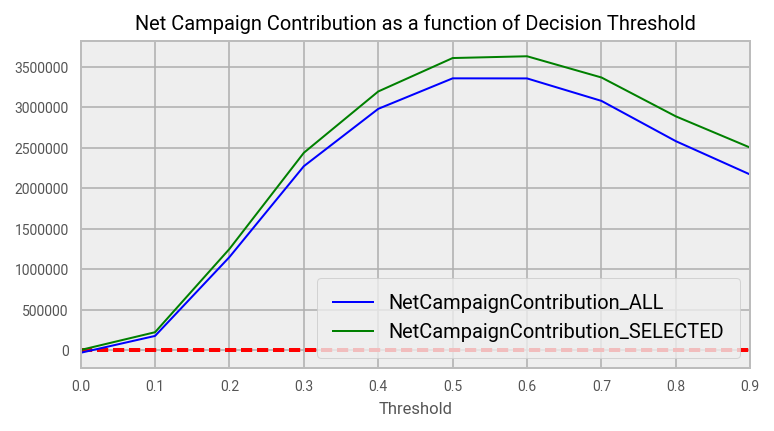

In [129]:
f, ax = plt.subplots(1, figsize=(6,3))
df_all.plot(ax=ax, color='b', markeredgewidth=10)
df_predicted.plot(ax=ax, color='g', markeredgewidth=10)
xs = np.linspace(1, 21, 200)
plt.hlines(y=40, xmin=0, xmax=len(xs), color='r', linestyles='--', lw=2)
ax.set_title("Net Campaign Contribution as a function of Decision Threshold")
plt.ticklabel_format(style = 'plain')
plt.show()

In [ ]:
#Saving the predictions

In [130]:
input_data = predictions.rdd.map(lambda x: (x["is_default"], DenseVector(x["probability"])))

In [131]:
temp = predictions.rdd.map(lambda x:(x["label"], [float(y) for y in x['probability']])).toDF(["label", "probability"])

In [132]:
temp = temp.toPandas()

In [133]:
temp = pd.DataFrame(temp.probability.apply(pd.Series).join(temp, how='inner'))

In [134]:
temp.columns = ['prob0', 'prob1', 'label', 'probability']

In [135]:
temp = temp.drop(columns=['prob0', 'probability'])

In [136]:
temp.to_csv("data/chosen_model/predictions/label_vs_pred.csv")